In [8]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os

plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'xtick.labelsize': 12})




In [24]:
## preprocessing functions
def visualize_rate(filename, ax):
    s1 = np.load(filename)
    df1 = pd.DataFrame()
    df1[0] = pd.to_datetime(s1.cumsum(), unit='s')
    df1 = df1.set_index(0)
    df1[1] = np.ones(len(df1))
    df1[1].rolling('1s').count().plot(ax=ax)
    
def plot_cdf(xvals, ax, **kwargs):
    x = np.sort(xvals)
    y = np.arange(len(x))/float(len(x))
    ax.plot(x,y, **kwargs)
    


# Motivation
---
## SF Cabs request arrival analysis

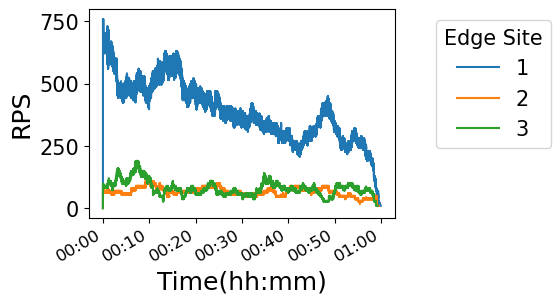

In [23]:
# fig,axs = plt.subplots(3,1, sharex=True, figsize=(3,8))
fig, ax = plt.subplots(figsize=(4,3))

from matplotlib.dates import DateFormatter
formatter = DateFormatter('%H:%M')
for i in range(3):
    visualize_rate(f'../loadgen/sfcabs-12-node-load/sfcabs-load-site{9+i}.npy',ax)
    ax.set_xlabel('')
ax.xaxis.set_major_formatter(formatter)

fig.tight_layout()
ax.legend(['1','2','3'], title='Edge Site', bbox_to_anchor=(1.1,1))
ax.set_ylabel('RPS', fontsize=18)
ax.set_xlabel('Time(hh:mm)', fontsize=18)
fig.savefig('/Users/anirudh/Workspace/fededge/paper/figs/varloads.pdf', bbox_inches='tight')

# Simulation
---

In [25]:
class LoadData:
    def __init__(self):
        self.ingress_clients     = None
        self.ingress_offloaded   = None
        self.total_executed      = None
        self.total_offloaded_out = None
        self.exec_latency        = None
        self.e2e_latency         = None
        self.offload_only_e2e_latency         = None
        self.local_e2e_latency         = None
        self.end_time            = None
        self.faas_count          = None
        
def load_data(filename):
    ometrics = {}
    with open(filename) as fh:
        ometrics = json.load(fh)
    data = LoadData()
    data.ingress_clients     = ometrics["ingress_clients"]    
    data.ingress_offloaded   = ometrics["ingress_offloaded"]  
    data.total_executed      = ometrics["total_executed"]     
    data.total_offloaded_out = ometrics["total_offloaded_out"]
    data.exec_latency        = ometrics["exec_latency"]       
    data.e2e_latency         = ometrics["e2e_latency"]        
    data.end_time            = ometrics["end_time"]
    data.faas_count          = ometrics["faas_count"]
    data.offload_only_e2e_latency         = ometrics["offload_only_e2e_latency"]
    data.local_e2e_latency         = ometrics["local_e2e_latency"]
    return data

def parse_result(pol, profile):
    root = f'/Users/anirudh/Workspace/fededge/paper/results/simulation/results/{pol}/{profile}/output_metrics.json'
    data = load_data(root)
    lats = {}
    for tag in ['all','local','offload']:
        lats[tag] = np.array([])

    for node in range(data.faas_count):
        
        lats['all'] = np.concatenate((lats['all'], data.e2e_latency[node][1]))
        lats['local'] = np.concatenate((lats['local'], data.local_e2e_latency[node][1]))
        lats['offload'] = np.concatenate((lats['offload'], data.offload_only_e2e_latency[node][1]))
    
    return lats

def group_by_pctls(lats, pctl):
    xvals = []
    for pctl in pctls:
        xvals.append(np.percentile(lats, pctl))
    return xvals


def plot_per_profile(profile, ax, **kwargs):
    pctls = [50,90,95,99,99.9]
    title = kwargs.pop('title')
    
    pols = [
    'ORACLE',
    'ROUNDROBIN',
    'CENTRALIZED',
    'HYBRID',
    'RTIME',
    'EPOCH_CENTRAL',
    'RANDOM',
    ]
    
    if 'pols' in kwargs:
        pols = kwargs.pop('pols')
    
    for pol in pols:
        lats = parse_result(pol, profile)

        # convert to ms
        xvals = 1000*lats['all']

        # !!for cdf
        # plot_cdf(xvals, ax, linewidth=linew)

        new_xvals = group_by_pctls(xvals,pctls)
        ax.plot(new_xvals, **kwargs)
        ax.set_xticks(np.arange(len(pctls)))
        ax.set_xticklabels(pctls)
        ax.set_title(title)

    # !!for cdf
    # ax.axvline(x=200, linestyle=':', color='black', linewidth=linew-1)


    # !!for cdf
    # ax.set_ylabel('CDF (requests)')
    # ax.set_xlabel('Latency (ms)')
    # ax.set_xlim(0,600)

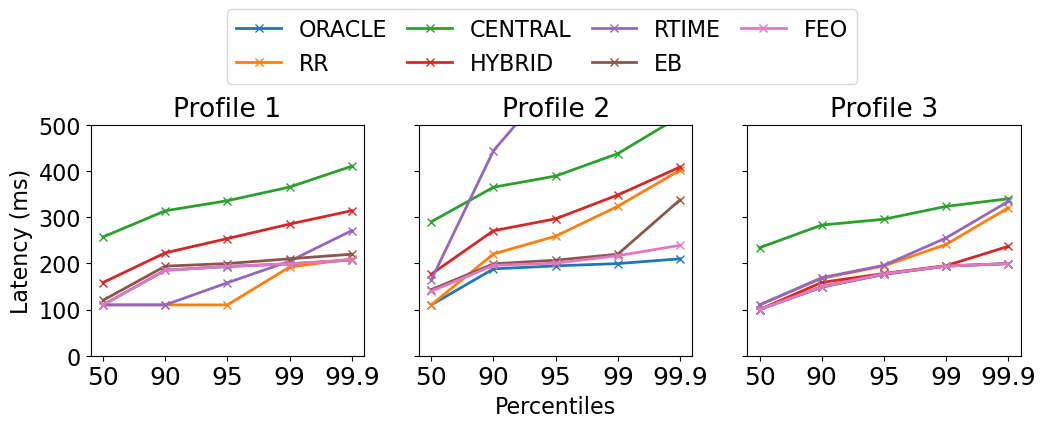

In [35]:
numsites=10
pctls = [50,90,95,99,99.9]

#label corrections
pollabs = [
    'ORACLE',
    'RR',
    'CENTRAL',
    'HYBRID',
    'RTIME',
    'EB',
    'FEO'
]


fig, axs = plt.subplots(1,3, figsize=(12,3), sharey=True)
linew=2


plot_per_profile('10node-load1-5ms', axs[0], title='Profile 1', linewidth=linew, marker='x')
plot_per_profile('10node-load2', axs[1], title='Profile 2', linewidth=linew, marker='x')
plot_per_profile('10node-load3', axs[2], title='Profile 3', linewidth=linew, marker='x')


axs[0].set_ylabel('Latency (ms)')
axs[1].set_xlabel('Percentiles')
axs[0].legend(pollabs, ncol=4, bbox_to_anchor=(0.5,-0.5,2.3,2.0),loc=1, mode='expand', borderaxespad=0.)
# fig.tight_layout()

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'xtick.labelsize': 18})
axs[0].set_ylim((0,500))
fig.savefig('/Users/anirudh/Workspace/fededge/paper/figs/simu-profile-eval.pdf',bbox_inches='tight')


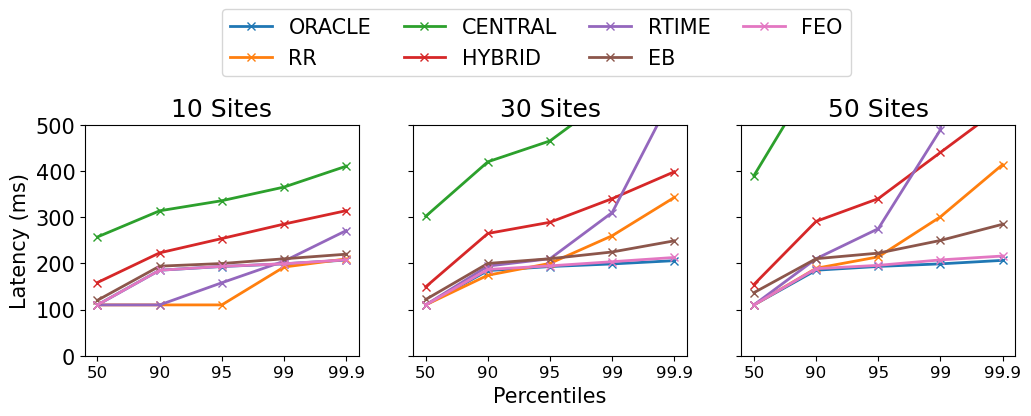

In [32]:
numsites=10

#label corrections
pollabs = [
    'ORACLE',
    'RR',
    'CENTRAL',
    'HYBRID',
    'RTIME',
    'EB',
    'FEO'
]

pctls = [50,90,95,99,99.9]

fig, axs = plt.subplots(1,3, figsize=(12,3), sharey=True)
linew=2
plot_per_profile('10node-load1-5ms', axs[0], title='10 Sites', linewidth=linew, marker='x')
plot_per_profile('30node-load1', axs[1], title='30 Sites', linewidth=linew, marker='x')
plot_per_profile('50node-load1', axs[2], title='50 Sites', linewidth=linew, marker='x')

axs[0].set_ylabel('Latency (ms)')
axs[1].set_xlabel('Percentiles')
axs[0].legend(pollabs, ncol=4, bbox_to_anchor=(0.5,-0.5,2.3,2.0),loc=1, mode='expand', borderaxespad=0.)
# fig.tight_layout()

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'xtick.labelsize': 18})
axs[0].set_ylim((0,500))
fig.savefig('/Users/anirudh/Workspace/fededge/paper/figs/simu-sitecount-eval.pdf',bbox_inches='tight')


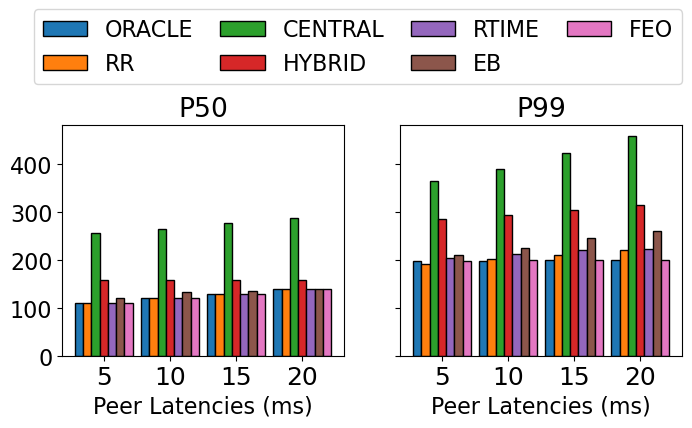

In [34]:
numsites=10

#label corrections
pollabs = [
    'ORACLE',
    'RR',
    'CENTRAL',
    'HYBRID',
    'RTIME',
    'EB',
    'FEO'
]

pols=['HYBRID']

fig, axs = plt.subplots(1,2, figsize=(8,3), sharey=True)
linew=2

pols = [
'ORACLE',
'ROUNDROBIN',
'CENTRALIZED',
'HYBRID',
'RTIME',
'EPOCH_CENTRAL',
'RANDOM',
]
 
ax = axs[0]
pctls = [50,90,95,99,99.9]
peerlats = [5,10,15,20]

p50a = {}
p99a = {}
p50a_forlat = [[] for _ in range(len(peerlats))]
p99a_forlat = [[] for _ in range(len(peerlats))]
grand_arr = np.empty(0)

for i,profile in enumerate([f'10node-load1-{t}ms' for t in peerlats]):
    final_arr = np.empty(0) 
    for pol in pols:
        if pol not in p50a:
            p50a[pol] = []
            p99a[pol] = []
            
        lats = parse_result(pol, profile)

        # convert to ms
        xvals = 1000*lats['all']
        new_xvals = group_by_pctls(xvals,pctls)
        if final_arr.size == 0:
            final_arr = np.array(new_xvals)
        else:
         
            final_arr = np.vstack((final_arr, new_xvals))
            
    if grand_arr.size != 0:
        grand_arr = np.concatenate((grand_arr,final_arr[np.newaxis,:]),axis=0)
    else:
        grand_arr = final_arr[np.newaxis,:]


## !!grandarray is profile x policy x percentile!!

# P50
xvals = np.arange(0,2*len(peerlats),2)
xticks = xvals.copy()
for i,pol in enumerate(pols):
    axs[0].bar(xvals, grand_arr[:,i,0], width=0.25, edgecolor='black')
    xvals = xvals + 0.25

axs[0].set_xticks(xticks+0.75)
axs[0].set_xticklabels(peerlats)
axs[0].set_title('P50')
axs[0].set_xlabel('Peer Latencies (ms)')


# P99
xvals = np.arange(0,2*len(peerlats),2)
xticks = xvals.copy()
for i,pol in enumerate(pols):
    axs[1].bar(xvals, grand_arr[:,i,-2], width=0.25, edgecolor='black')
    xvals = xvals + 0.25

axs[1].set_xticks(xticks+0.75)
axs[1].set_xticklabels(peerlats)
axs[1].set_title('P99')
axs[1].set_xlabel('Peer Latencies (ms)')



axs[0].legend(pollabs, ncol=4, bbox_to_anchor=(-0.1,-0.5,2.3,2.0),loc=1, mode='expand', borderaxespad=0.)
# fig.tight_layout()

# plt.rcParams.update({'font.size': 16})
# plt.rcParams.update({'xtick.labelsize': 18})
# axs[0].set_ylim((0,200))
fig.savefig('/Users/anirudh/Workspace/fededge/paper/figs/simu-peerlats-eval.pdf',bbox_inches='tight')


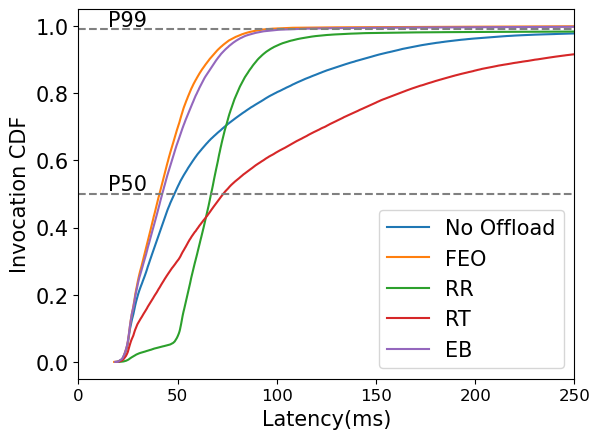

In [30]:

def get_arr(path):
    files = os.listdir(path)
    final_arr = np.array([])
    for file in files:
        if 'lats' not in file:
            continue
        fn = f'{path}{file}'
        try:
            df = pd.read_csv(fn, header=None)
            final_arr = np.hstack((final_arr, df[0].values))
        except:
            continue
            
        
    return final_arr


fig, ax = plt.subplots()
sites = range(12)
# sites = [9]

arrs = []
for i in sites:
    arr = get_arr(f'../feodata/drone/debug/diffc-2c-test//base/site{i}/drone_results/')
    arrs.append(arr)
base = np.hstack(arrs)
plot_cdf(base, ax)

arrs = []
for i in sites:
    arr = get_arr(f'../feodata/drone/debug/diffc-2c-test//federated/site{i}/drone_results/')
    arrs.append(arr)
fed = np.hstack(arrs)
plot_cdf(fed, ax)

arrs = []
for i in sites:
    arr = get_arr(f'../feodata/drone/debug/diffc-2c-test//roundrobin/site{i}/drone_results/')
    arrs.append(arr)
rr = np.hstack(arrs)
plot_cdf(rr, ax)

arrs = []
for i in sites:
    arr = get_arr(f'../feodata/drone/debug/diffc-2c-test//roundrobinlatency/site{i}/drone_results/')
    arrs.append(arr)
rt = np.hstack(arrs)
plot_cdf(rt, ax)

arrs = []
for i in sites:
    arr = get_arr(f'../feodata/drone/debug/diffc-2c-test//epoch/site{i}/drone_results/')
    arrs.append(arr)
epoch = np.hstack(arrs)
plot_cdf(epoch, ax)

ax.legend(['No Offload','FEO','RR','RT','EB'])
ax.set_xlim(0,250)
ax.set_ylabel('Invocation CDF')
ax.set_xlabel('Latency(ms)')

ax.axhline(.99, linestyle='dashed', color='gray')
ax.axhline(.50, linestyle='dashed', color='gray')
ax.annotate('P99', (15,1))
ax.annotate('P50', (15,.51))
fig.savefig('../paper/figs/drone-eval.pdf', bbox_inches='tight')